In [1]:
import os
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import math

In [2]:
tf.executing_eagerly()
tf.config.list_physical_devices('GPU')

[]

In [3]:
seed=2222
np.random.seed(seed)
tf.random.set_seed(seed)

size_input = 28*28
size_hidden_1 = 256
size_hidden_2 = 128
size_output = 10
batch_size=30
lr=0.001
dropout_p=0.0
L1=0
L2=3e-5

fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train=tf.reshape(x_train,[x_train.shape[0],-1])
x_test=tf.reshape(x_test,[x_test.shape[0],-1])

x_train, x_valid = tf.split(  
            x_train,
            num_or_size_splits=[55000, 5000],
            axis=0
        )
y_train, y_valid = tf.split(
            y_train,
            num_or_size_splits=[55000, 5000],
            axis=0
        )
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_valid.shape)
print(y_valid.shape)
print(y_test[0:20])

(55000, 784)
(55000,)
(10000, 784)
(10000,)
(5000, 784)
(5000,)
[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0]


In [4]:
class MLP(tf.keras.Model):
  def __init__(self, size_input, size_hidden_1, size_hidden_2, size_output, device=None):
    super(MLP, self).__init__()
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """

    self.size_input, self.size_hidden_1, self.size_hidden_2, self.size_output, self.device =\
    size_input, size_hidden_1, size_hidden_2, size_output, device

    self.initial=tf.keras.initializers.he_normal(seed=seed)
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(self.initial([self.size_input, self.size_hidden_1]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(self.initial([1, self.size_hidden_1]))
     # Initialize weights between hidden layer and output layer
    self.W2 = tf.Variable(self.initial([self.size_hidden_1, self.size_hidden_2]))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(self.initial([1, self.size_hidden_2]))
     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(self.initial([self.size_hidden_2, self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(self.initial([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.MLP_variables = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]

    self.loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    self.reg_12=tf.keras.regularizers.L1L2(l1=L1, l2=L2)

    self.t=0
    self.m=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32)]
    self.u=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32)]
    self.v=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32)]
    
  def forward(self, training, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if training==1:
      if self.device is not None:
        with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output(X)
      else:
        self.y = self.compute_output(X)
    elif training==0:
      if self.device is not None:
        with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output_test(X)
      else:
        self.y = self.compute_output_test(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    return self.loss_object(y_true, y_pred)+self.reg_12(self.W1)+self.reg_12(self.W2)

  def loss2(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    return self.loss_object(y_true, y_pred)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """

    '''
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    with tf.GradientTape() as tape:
      predicted = self.forward(1,X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.MLP_variables)
    optimizer.apply_gradients(zip(grads, self.MLP_variables))
    '''

    self.t=self.t+1
    beta_1=0.9
    beta_2=0.999
    beta_3=0.999987
    ep=0.00000001
    
    with tf.GradientTape() as tape:
      predicted = self.forward(1,X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.MLP_variables)

    

    self.m=[a_i*beta_1+(1-beta_1)*b_i for a_i, b_i in zip(self.m, grads) ]
    self.u=[a_i*beta_2+(1-beta_2)*(b_i**2) for a_i, b_i in zip(self.u, grads) ]
    self.v=[a_i*beta_3+(1-beta_3)*(b_i**3) for a_i, b_i in zip(self.v, grads) ]

    hm=[a_i/(1-(beta_1**self.t)) for a_i in self.m]
    hu=[a_i/(1-(beta_2**self.t)) for a_i in self.u]
    hv=[a_i/(1-(beta_3**self.t)) for a_i in self.v]
    hv_sign=[tf.math.sign(a_i) for a_i in hv] #Here tf.pow can only handle positive number, so I seperate the sign of hv and abs(hv)
    hv_abs=[tf.abs(a_i) for a_i in hv]

    dws_new=[lr * a_i /(ep + tf.sqrt(b_i)+(d_i*tf.pow(c_i,1.0/3.0)*ep)) for a_i, b_i, c_i, d_i in zip(hm, hu, hv_abs,hv_sign)] 

    #print(type(dws[0:1]))
    Wt = [a_i - b_i for a_i, b_i in zip(self.variables, dws_new)]
    #print(type(Wt))

    for i in range(len(self.variables)):
      self.variables[i].assign(Wt[i])

        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)
    hhat = tf.nn.dropout(hhat, rate = dropout_p, seed = seed)
    what_1 = tf.matmul(hhat, self.W2) + self.b2
    hhat_1 = tf.nn.relu(what_1)
    hhat_1 = tf.nn.dropout(hhat_1, rate = dropout_p, seed = seed)
    # Compute output
    what_2 = tf.matmul(hhat_1, self.W3) + self.b3
    #output= tf.nn.softmax(what_2)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return what_2

  def compute_output_test(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)
    what_1 = tf.matmul(hhat, self.W2) + self.b2
    hhat_1 = tf.nn.relu(what_1)
    # Compute output
    what_2 = tf.matmul(hhat_1, self.W3) + self.b3
    #output= tf.nn.softmax(what_2)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return what_2
  

In [5]:
t=np.array([[[1,1],[2,2]],[[3,2],[2,3]]])
print(tf.reshape(t,[2,1,-1]))
t.shape

tf.Tensor(
[[[1 1 2 2]]

 [[3 2 2 3]]], shape=(2, 1, 4), dtype=int32)


(2, 2, 2)

In [6]:
# Set number of epochs
NUM_EPOCHS = 30

In [7]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

train_loss.reset_states()
train_accuracy.reset_states()
val_loss.reset_states()
val_accuracy.reset_states()

mlp_on_default = MLP(size_input, size_hidden_1, size_hidden_2, size_output)

valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(batch_size)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000, seed=seed).batch(batch_size)

for inputs, outputs in valid_ds:
  preds = mlp_on_default.forward(0,inputs)
  val_loss(mlp_on_default.loss2(preds,outputs))
  val_accuracy(outputs, preds)

print(
  f'Epoch {0}, '
  f'Val Loss: {val_loss.result()}, '
  f'Val Accuracy: {val_accuracy.result() * 100}'
)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  
  for inputs, outputs in train_ds:
    mlp_on_default.backward(inputs, outputs)
    preds = mlp_on_default.forward(0,inputs)
    train_loss(mlp_on_default.loss(preds,outputs))
    train_accuracy(outputs, preds)

  for inputs, outputs in valid_ds:
    preds = mlp_on_default.forward(0,inputs)
    val_loss(mlp_on_default.loss2(preds,outputs))
    val_accuracy(outputs, preds)
  
  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Val loss: {val_loss.result()}, '
    f'Val Accuracy: {val_accuracy.result() * 100}'
  )

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Epoch 0, Val Loss: 3.3782835006713867, Val Accuracy: 10.760000228881836
Epoch 1, Loss: 0.46646252274513245, Accuracy: 83.91999816894531, Val loss: 0.38224250078201294, Val Accuracy: 85.55999755859375
Epoch 2, Loss: 0.3605271875858307, Accuracy: 87.46363830566406, Val loss: 0.36480724811553955, Val Accuracy: 86.23999786376953
Epoch 3, Loss: 0.32491162419319153, Accuracy: 88.94363403320312, Val loss: 0.3876471519470215, Val Accuracy: 86.58000183105469
Epoch 4, Loss: 0.30636054277420044, Accuracy: 89.66181945800781, Val loss: 0.3710869252681732, Val Accuracy: 86.5999984741211
Epoch 5, Loss: 0.29303669929504395, Accuracy: 90.26363372802734, Val loss: 0.319844514131546, Val Accuracy: 88.31999969482422
Epoch 6, Loss: 0.2816931903362274, Accuracy: 90.68727111816406, Val loss: 0.330579549074173, Val Accuracy: 88.31999969482422
Epoch 7, Loss: 0.2720288038253784, Accuracy: 91.0309066772461, Val loss: 0.40357208251953125, Val Accuracy: 86.15999603271484
Epoch 8, Loss: 0.265185683965683, Accuracy:

In [8]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

test_loss.reset_states()
test_accuracy.reset_states()

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(0,inputs)
  test_loss(mlp_on_default.loss2(preds,outputs))
  test_accuracy(outputs, preds)

print(
  f'Epoch {0}, '
  f'Test Loss: {test_loss.result()}, '
  f'Test Accuracy: {test_accuracy.result() * 100}'
)

Epoch 0, Test Loss: 0.4010942280292511, Test Accuracy: 88.13999938964844


No handles with labels found to put in legend.


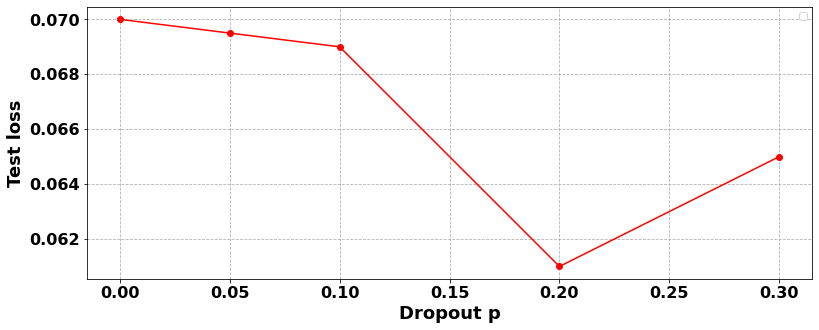

In [9]:
plt.figure(figsize=(13,5))
plt.grid(linestyle = "--") 
ax = plt.gca()

x_c = np.array([0.0,0.05,0.1,0.2,0.3]) 
C=np.array([0.07,0.0695,0.069,0.061,0.065])  

plt.plot(x_c,C,'ro-',linewidth=1.5)
#ax.fill_between(x_c, (C1), (C2), color='r', alpha=.1)
plt.xticks(fontsize=16,fontweight='bold') 
plt.yticks(fontsize=16,fontweight='bold')
plt.xlabel("Dropout p",fontsize=18,fontweight='bold')
plt.ylabel("Test loss",fontsize=18,fontweight='bold')
#plt.xlim(-0.5,3.5)
#plt.ylim(0.5,1.5)
#x_major_locator=plt.MultipleLocator(1)
#y_major_locator=plt.MultipleLocator(0.2)
#ax.xaxis.set_major_locator(x_major_locator)
#ax.yaxis.set_major_locator(y_major_locator)
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=18,fontweight='bold') 
plt.show()

No handles with labels found to put in legend.


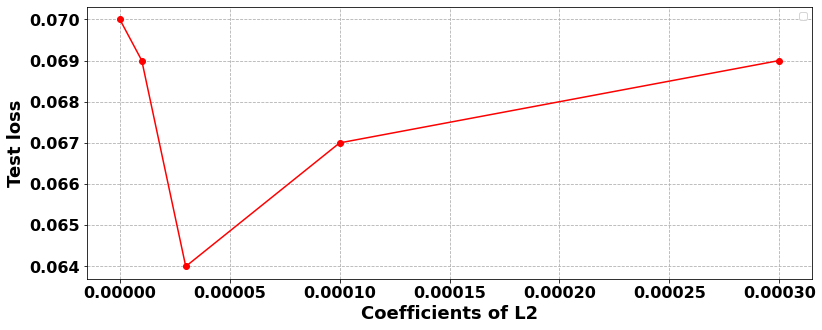

In [10]:
plt.figure(figsize=(13,5))
plt.grid(linestyle = "--") 
ax = plt.gca()

x_c = np.array([0.0,0.00001,0.00003,0.0001,0.0003]) 
C=np.array([0.07,0.069,0.064,0.067,0.069])  

plt.plot(x_c,C,'ro-',linewidth=1.5)
#ax.fill_between(x_c, (C1), (C2), color='r', alpha=.1)
plt.xticks(fontsize=16,fontweight='bold') 
plt.yticks(fontsize=16,fontweight='bold')
plt.xlabel("Coefficients of L2",fontsize=18,fontweight='bold')
plt.ylabel("Test loss",fontsize=18,fontweight='bold')
#plt.xlim(-0.5,3.5)
#plt.ylim(0.5,1.5)
#x_major_locator=plt.MultipleLocator(1)
#y_major_locator=plt.MultipleLocator(0.2)
#ax.xaxis.set_major_locator(x_major_locator)
#ax.yaxis.set_major_locator(y_major_locator)
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=18,fontweight='bold') 
plt.show()